In [1]:
import sys
import os
import numpy as np
import xarray as xr
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.metrics import brier_score_loss
from sklearn.linear_model import LogisticRegression
from scipy.stats import gaussian_kde

sys.path.append(os.path.expanduser('~/Documents/Hybrid/'))
from Hybrid.neuralnet import construct_modeldev_model, earlystop, BrierScore, ConstructorAndCompiler
#from Hybrid.optimization import multi_fit_multi_eval, multi_fit_single_eval, ranked_prob_score
from Hybrid.dataprep import test_trainval_split, multiclass_log_forecastprob, singleclass_regression, multiclass_logistic_regression_coefficients, scale_other_features, scale_time
from Hybrid.interpretation import combine_input_output, composite_extremes

sys.path.append(os.path.expanduser('~/Documents/Weave/'))
from Weave.utils import reliability_plot

crossval = True # Only for the trainvalsplit.
nfolds = 3
balanced = True
focus_class = -1 # Index of the class to be scored and benchmarked through bss

name = 'tg-anom_JJA_45r1_31D-roll-mean_q05_sep12-15'
#name = 'tg-ex-q0.75-21D_ge7D_sep12-15'
#name2 = 'tg-anom_JJA_45r1_21D-roll-mean_sep12-15'

predictor_dir = Path('/nobackup/users/straaten/predsets/objective_balanced_cv/') # Can change to the objectively selected sets
#predictor_dir = Path('/nobackup/users/straaten/predsets/objective_balanced_cv/emp_duplicated/') # Can change to the objectively selected sets
for_obs_dir = Path('/nobackup/users/straaten/predsets/full/') 

predictors = pd.read_hdf(predictor_dir / f'{name}_multi_d20_b3_predictors.h5', key = 'input').iloc[:,:4]
forc = pd.read_hdf(for_obs_dir / f'{name}_forc.h5', key = 'input')
obs= pd.read_hdf(for_obs_dir / f'{name}_obs.h5', key = 'target')

2021-12-16 15:49:36.541301: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-16 15:49:36.541320: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Splitting the sets.
X_test, X_trainval, generator = test_trainval_split(predictors, crossval = crossval, nfolds = nfolds, balanced = balanced)
forc_test, forc_trainval, generator = test_trainval_split(forc, crossval = crossval, nfolds = nfolds, balanced = balanced)
obs_test, obs_trainval, generator = test_trainval_split(obs, crossval = crossval, nfolds = nfolds, balanced = balanced)

# Prepare trainval data for the neural network
features_trainval, feature_scaler = scale_other_features(X_trainval)
logforc_trainval = multiclass_log_forecastprob(forc_trainval)
obsinp_trainval = obs_trainval.values

# Preparing the test set
features_test, _ = scale_other_features(X_test, fitted_scaler=feature_scaler)
logforc_test = multiclass_log_forecastprob(forc_test)

fitting a new feature scaler
using a pre-fitted feature scaler


In [27]:
# Setting up the model
construct_kwargs = dict(n_classes = obs_trainval.shape[-1],
        n_hidden_layers= 1,
        n_features = features_trainval.shape[-1],
        n_hiddenlayer_nodes = 4)

compile_kwargs = dict(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0014),
        metrics = ['accuracy',BrierScore(class_index = focus_class)])

constructor = ConstructorAndCompiler(construct_modeldev_model, construct_kwargs, compile_kwargs)

fit_kwargs = dict(batch_size = 32, epochs = 200, shuffle = True, callbacks = [earlystop(patience = 7, monitor = 'val_loss')])

In [28]:
# Training the model
model = constructor.fresh_model()
model.fit(x = [features_trainval, logforc_trainval], y=obsinp_trainval, validation_split = 0.33, **fit_kwargs)

# Training a trend benchmark model, and generating scale test time input
time_input, time_scaler, lr = singleclass_regression(obs_trainval.iloc[:,focus_class], regressor = LogisticRegression)
time_test, _ = scale_time(obs_test, fitted_scaler=time_scaler)

Epoch 1/200
41/41 [==============================] - 0s 3ms/step - loss: 0.7267 - accuracy: 0.5498 - brier: 0.2600 - val_loss: 0.7861 - val_accuracy: 0.4826 - val_brier: 0.2892
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.7235 - accuracy: 0.5498 - brier: 0.2585 - val_loss: 0.7836 - val_accuracy: 0.4826 - val_brier: 0.2883
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.7189 - accuracy: 0.5529 - brier: 0.2563 - val_loss: 0.7801 - val_accuracy: 0.4826 - val_brier: 0.2868
Epoch 4/200
41/41 [==============================] - 0s 995us/step - loss: 0.7109 - accuracy: 0.5848 - brier: 0.2525 - val_loss: 0.7741 - val_accuracy: 0.4968 - val_brier: 0.2844
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6997 - accuracy: 0.5933 - brier: 0.2473 - val_loss: 0.7671 - val_accuracy: 0.5016 - val_brier: 0.2814
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6851 - accuracy: 0.5964 - brier: 0.240

41/41 [==============================] - 0s 1ms/step - loss: 0.5329 - accuracy: 0.7628 - brier: 0.1699 - val_loss: 0.6218 - val_accuracy: 0.6309 - val_brier: 0.2184
Epoch 48/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5333 - accuracy: 0.7582 - brier: 0.1701 - val_loss: 0.6274 - val_accuracy: 0.6404 - val_brier: 0.2199
Epoch 49/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5329 - accuracy: 0.7605 - brier: 0.1701 - val_loss: 0.6258 - val_accuracy: 0.6404 - val_brier: 0.2194
Epoch 50/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5332 - accuracy: 0.7628 - brier: 0.1700 - val_loss: 0.6190 - val_accuracy: 0.6309 - val_brier: 0.2177
Epoch 51/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5335 - accuracy: 0.7589 - brier: 0.1705 - val_loss: 0.6331 - val_accuracy: 0.6356 - val_brier: 0.2218
Epoch 52/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5330 - accuracy: 0.7706 - brier: 0.1696 - val_l

In [22]:
# Generating model predictions:
preds_test = model.predict(x = [features_test, logforc_test])
preds_trainval = model.predict(x = [features_trainval, logforc_trainval])
# Generating benchmark predictions:
trend_test = lr.predict(time_test)
trend_trainval = lr.predict(time_input)

In [130]:
n_iter = 2000
bs = pd.DataFrame(np.nan, columns = pd.MultiIndex.from_product([['trainval','test'],['raw','trend','neural']], names = ['set','forecast']), index = pd.RangeIndex(n_iter))
for i in range(n_iter):

    train_sample = np.random.randint(low = 0, high = obs_trainval.shape[0], size = obs_trainval.shape[0]) # bootstrap sample with replacement.
    test_sample = np.random.randint(low = 0, high = obs_test.shape[0], size = obs_test.shape[0])
    
    bs.loc[i,('test','raw')] = brier_score_loss(obs_test.values[test_sample,focus_class],forc_test.values[test_sample,focus_class])
    bs.loc[i,('test','trend')] = brier_score_loss(obs_test.values[test_sample,focus_class],trend_test[test_sample])
    bs.loc[i,('test','neural')] = brier_score_loss(obs_test.values[test_sample,focus_class],preds_test[test_sample,focus_class])
    
    bs.loc[i,('trainval','raw')] = brier_score_loss(obs_trainval.values[train_sample,focus_class],forc_trainval.values[train_sample,focus_class])
    bs.loc[i,('trainval','trend')] = brier_score_loss(obs_trainval.values[train_sample,focus_class],trend_trainval[train_sample])
    bs.loc[i,('trainval','neural')] = brier_score_loss(obs_trainval.values[train_sample,focus_class],preds_trainval[train_sample,focus_class])

In [138]:
# scale test and trainval BS separately based on the mean raw score
bszero = bs.copy()
bszero['test'] = bs['test'] - float(bs[('test', 'raw')].mean())
bszero['trainval'] = bs['trainval'] - float(bs[('trainval', 'raw')].mean())

# BSS
bss = bs.copy()
bss['test'] = 1 - bs['test'] / bs[[('test', 'raw')]].values
bss['trainval'] = 1 - bs['trainval'] / bs[[('trainval', 'raw')]].values
bss = bss.loc[:,(slice(None),['trend','neural'])]

In [147]:
def to_kernel_density(vals):
    if isinstance(vals, (pd.Series, pd.DataFrame)):
        vals = vals.values.squeeze()
    positions = np.linspace(start = vals.min(), stop = vals.max(), num = 100)
    density = gaussian_kde(vals)(positions)
    return(positions, density)

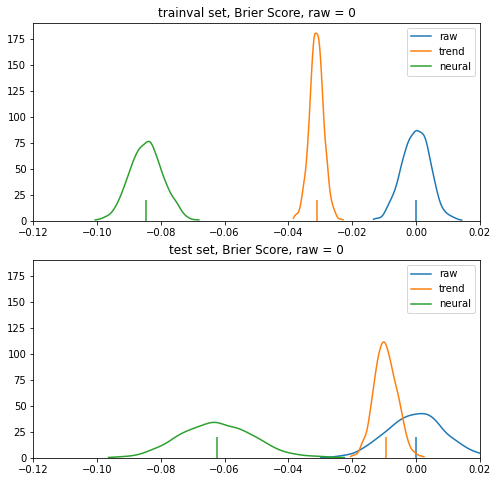

In [159]:
fig, axes = plt.subplots(ncols=1, nrows = 2, figsize = (8,8), squeeze = False)
for key in bszero.columns:
    i = bszero.columns.get_level_values(0).unique().tolist().index(key[0])
    ax = axes[i,0]
    #ax.hist(bszero[key], label = key[-1], histtype = 'step')
    im = ax.plot(*to_kernel_density(bszero[key]),label = key[-1])
    ax.vlines(x = float(bszero[key].mean()), ymin=0, ymax = 20, color = im[0].get_c())
    #ax.set_xlim(left = -0.12, right = 0.08)
    ax.set_xlim(left = -0.12, right = 0.02)
    ax.set_ylim(0,190)
    ax.set_title(f'{key[0]} set, Brier Score, raw = 0')
    ax.legend()

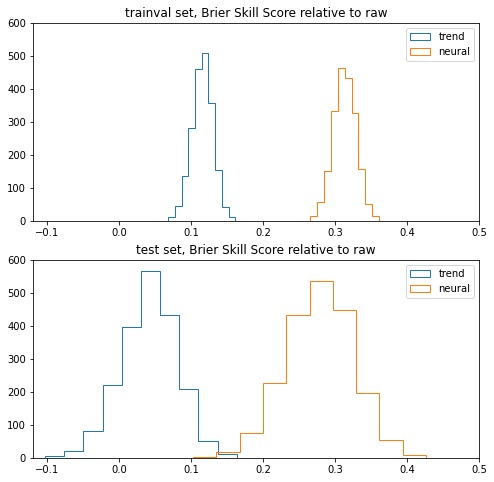

In [142]:
fig, axes = plt.subplots(ncols=1, nrows = 2, figsize = (8,8), squeeze = False)
for key in bss.columns:
    i = bss.columns.get_level_values(0).unique().tolist().index(key[0])
    ax = axes[i,0]
    ax.hist(bss[key], label = key[-1], histtype = 'step')
    #ax.set_xlim(left = -0.12, right = 0.08)
    ax.set_xlim(left = -0.12, right = 0.5)
    ax.set_ylim(0,600)
    ax.set_title(f'{key[0]} set, Brier Skill Score relative to raw')
    ax.legend()

In [23]:
complete_test = pd.DataFrame({'raw':forc_test.iloc[:,focus_class], 'trend': trend_test,'neural':preds_test[:,focus_class]}, index = forc_test.index)
complete_test.columns.name = 'type'

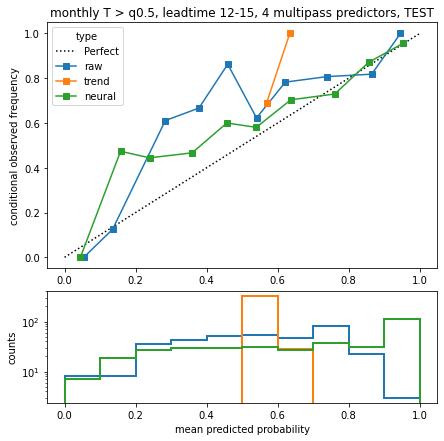

In [7]:
fig, (axrel, axhist) = reliability_plot(y_true = obs_test.iloc[:,focus_class], y_probs=complete_test)
axrel.set_title('monthly T > q0.5, leadtime 12-15, 4 multipass predictors, TEST')
plt.show()

In [25]:
complete_train = pd.DataFrame({'raw':forc_trainval.iloc[:,focus_class],'trend': trend_trainval,'neural':preds_trainval[:,focus_class]}, index = forc_trainval.index)
complete_train.columns.name = 'type'

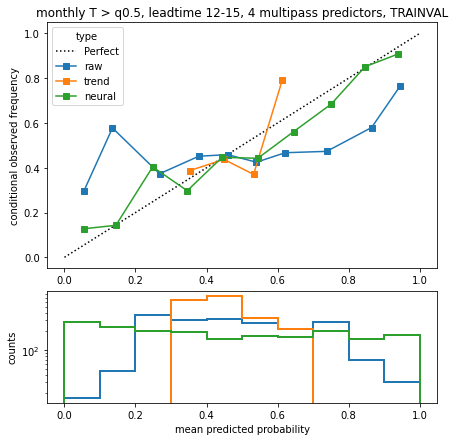

In [9]:
fig, (axrel, axhist) = reliability_plot(y_true = obs_trainval.iloc[:,focus_class], y_probs =complete_train)
axrel.set_title('monthly T > q0.5, leadtime 12-15, 4 multipass predictors, TRAINVAL')
plt.show()